#Sample training script with naive competitive self-play.

# Switch directory in Google drive so as to import CDA env.


In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd

#!pip install -r requirements.txt

#!pip install tensorflow==2.2.0
#!pip install ray[rllib]==0.8.5

#!pip show tensorflow
#!pip show ray

#!pip freeze > requirements.txt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction


#Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

from collections import defaultdict
from typing import Dict

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.policy import Policy
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.env import BaseEnv
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies, create_train_policy_list
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import storage
from gym_continuousDoubleAuction.train.callbk.callbk_handler import store_eps_hist_data
#from gym_continuousDoubleAuction.train.logger.log_handler import
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_storage, plot_LOB_subplot, plot_sum_ord_imb, plot_mid_prices
from gym_continuousDoubleAuction.train.helper.helper import ord_imb, sum_ord_imb, mid_price

tf = try_import_tf()

#Global


In [3]:
# CDA_env args
num_agents = 4
num_trained_agent = 2 # 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 256 # per episode, -1 in arg. (~7.2s/1000steps/iter)
is_render = False 

# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
#num_cpus = 0.25                                
num_gpus = 0.25                        
num_cpus_per_worker = 0.25                                
num_gpus_per_worker = 0.25  
num_workers = 2
num_envs_per_worker = 4
rollout_fragment_length = 32
train_batch_size = max_step
sgd_minibatch_size = 64
num_iters = 1

log_base_dir = "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/"
log_dir = log_base_dir + "ray_results/"

# Chkpt & restore
local_dir = log_base_dir + "chkpt/"
chkpt_freq = 10
chkpt = 150
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False

"""
# log & load 
write_last_eps_steps_dir = log_base_dir + "last_eps_steps/"
write_eps_dir = log_base_dir + "eps/"
create_dir(write_last_eps_steps_dir)    
create_dir(write_eps_dir)    
threshold = log_threshold(num_workers, num_envs_per_worker, num_iters, num_agents)
print("threshold", threshold)
"""

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

# Global storage, a ray actor that run on it's own process & it needs to be declared after ray.init().
g_store = storage.options(name="g_store", detached=True).remote(num_agents)

2020-06-15 14:17:44,422	INFO resource_spec.py:212 -- Starting Ray with 7.13 GiB memory available for workers and up to 3.58 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


train_policy_list =  ['policy_0', 'policy_1']


2020-06-15 14:17:44,890	INFO services.py:1170 -- View the Ray dashboard at 127.0.0.1:8265


#Policies

In [4]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:            
            return "policy_{}".format(i)                

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {})}


# Call back.

In [0]:
class MyCallbacks(DefaultCallbacks):
    def on_episode_start(self, worker: RolloutWorker, base_env: BaseEnv,
                         policies: Dict[str, Policy],
                         episode: MultiAgentEpisode, **kwargs):
        """
        info["episode"] is a MultiAgentEpisode object.

        user_data dicts at 100000 items max, will auto replace old with new item at 1st index.
        hist_data dicts at 100 items max, will auto replace old with new item at 1st index.
        """
        #print("on_episode_start {}, _agent_to_policy {}".format(episode.episode_id, episode._agent_to_policy))

        prefix = "agt_"
        for i in range(num_agents):
            episode.user_data[prefix + str(i) + "_obs"] = []
            episode.user_data[prefix + str(i) + "_act"] = []
            episode.user_data[prefix + str(i) + "_reward"] = []
            episode.user_data[prefix + str(i) + "_NAV"] = []
            episode.user_data[prefix + str(i) + "_num_trades"] = []

            episode.hist_data[prefix + str(i) + "_reward"] = []
            episode.hist_data[prefix + str(i) + "_NAV"] = []
            episode.hist_data[prefix + str(i) + "_num_trades"] = []

    def on_episode_step(self, worker: RolloutWorker, base_env: BaseEnv,
                        episode: MultiAgentEpisode, **kwargs):
        """
        pole_angle = abs(episode.last_observation_for()[2])
        raw_angle = abs(episode.last_raw_obs_for()[2])
        assert pole_angle == raw_angle
        episode.user_data["pole_angles"].append(pole_angle)
        """

        prefix = "agt_"
        for i in range(num_agents):
            obs = episode.last_raw_obs_for(i)
            #obs = episode.last_observation_for(i)
            act = episode.last_action_for(i)
            reward = episode.last_info_for(i).get("reward")
            NAV = episode.last_info_for(i).get("NAV")
            NAV = None if NAV is None else float(NAV)
            num_trades = episode.last_info_for(i).get("num_trades")
        
            if reward is None:      # goto next agent.
                continue

            episode.user_data[prefix + str(i) + "_obs"].append(obs)    
            episode.user_data[prefix + str(i) + "_act"].append(act)    
            episode.user_data[prefix + str(i) + "_reward"].append(reward)    
            episode.user_data[prefix + str(i) + "_NAV"].append(NAV)    
            episode.user_data[prefix + str(i) + "_num_trades"].append(num_trades)          

    def on_episode_end(self, worker: RolloutWorker, base_env: BaseEnv,
                       policies: Dict[str, Policy], episode: MultiAgentEpisode,
                       **kwargs):
        #print("on_episode_end {}, episode.agent_rewards {}".format(episode.episode_id, episode.agent_rewards))
        """
        arg: {"env": .., "episode": ...}
        """

        g_store = ray.util.get_actor("g_store")
        prefix = "agt_"
        for agt_id in range(num_agents):
            obs_key = prefix + str(agt_id) + "_obs"
            act_key = prefix + str(agt_id) + "_act"
            reward_key = prefix + str(agt_id) + "_reward"
            NAV_key = prefix + str(agt_id) + "_NAV"
            num_trades_key = prefix + str(agt_id) + "_num_trades"      

            # store into episode.hist_data
            store_eps_hist_data(episode, reward_key)
            store_eps_hist_data(episode, NAV_key)
            store_eps_hist_data(episode, num_trades_key)

            # store step data
            obs = episode.user_data[obs_key]
            act = episode.user_data[act_key]
            reward = episode.user_data[reward_key]
            NAV = episode.user_data[NAV_key]
            num_trades = episode.user_data[num_trades_key]
            ray.get(g_store.store_agt_step.remote(agt_id, obs, act, reward, NAV, num_trades))       
        
            # Store episode data.   
            eps_reward = np.sum(reward)
            eps_NAV = np.sum(NAV)
            eps_num_trades = np.sum(num_trades)
            ray.get(g_store.store_agt_eps.remote(agt_id, eps_reward, eps_NAV, eps_num_trades))

        ray.get(g_store.inc_eps_counter.remote())  

    def on_sample_end(self, worker: RolloutWorker, samples: SampleBatch,
                      **kwargs):
        """
        arg: {"samples": .., "worker": ...}

        Notes:
            https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py        
        """
        #print("on_sample_end returned sample batch of size {}".format(samples.count))

        """
        MultiAgentBatch_obj = info["samples"]
        MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
        MultiAgentBatch_count = MultiAgentBatch_obj.count

        access_sample_batches(MultiAgentBatch_policy_batches)
        print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
        print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object
        """

    def on_train_result(self, trainer, result: dict, **kwargs):
        """
        info["trainer"] is the trainer object.

        info["result"] contains a bunch of info such as episodic rewards for 
        each policy in info["result"][hist_stats] dictionary.
        """
        #print("trainer.train() result: {} -> {} episodes".format(trainer, result["episodes_this_iter"]))
        # you can mutate the result dict to add new fields to return
        result["callback_ok"] = True
        #print("on_train_result result", result)
    
        train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
        max_reward_ind = get_max_reward_ind(result, train_policies_name)
        max_reward_policy_name = train_policies_name[max_reward_ind]
        cp_weight(trainer, train_policies_name, max_reward_policy_name)    

        g_store = ray.util.get_actor("g_store")      
        prefix = "policy_policy_"
        suffix = "_reward"
        hist_stats = result["hist_stats"]
        eps_this_iter = result["episodes_this_iter"]
        for agt_id in range(num_agents):
            key = prefix + str(agt_id) + suffix
            for i in range(eps_this_iter):
                ray.get(g_store.store_agt_train.remote(agt_id, hist_stats[key][i]))

        #print("on_train_result info['result'] {}".format(info["result"]))     

    def on_postprocess_trajectory(
            self, worker: RolloutWorker, episode: MultiAgentEpisode,
            agent_id: str, policy_id: str, policies: Dict[str, Policy],
            postprocessed_batch: SampleBatch,
            original_batches: Dict[str, SampleBatch], **kwargs):
        #print("postprocessed {}, {}, {}, {} steps".format(episode, agent_id, policy_id, postprocessed_batch.count))
        """
        if "num_batches" not in episode.custom_metrics:
            episode.custom_metrics["num_batches"] = 0
        episode.custom_metrics["num_batches"] += 1        

        arg: {"agent_id": ..., "episode": ...,
              "pre_batch": (before processing),
              "post_batch": (after processing),
              "all_pre_batches": (other agent ids)}

        # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
        Dictionaries in a sample_obj, k:
            t
            eps_id
            agent_index
            obs
            actions
            rewards
            prev_actions
            prev_rewards
            dones
            infos
            new_obs
            action_prob
            action_logp
            vf_preds
            behaviour_logits
            unroll_id       
        """

        """
        policy_obj = info["pre_batch"][0]
        sample_obj = info["pre_batch"][1]    
        agt_id = info["agent_id"]
        eps_id = info["episode"].episode_id
        """        

#RLlib config

In [0]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    #config["num_cpus"] = num_cpus     # trainer, applicable only when using tune.
    config["num_gpus"] = num_gpus     # trainer
    config["num_cpus_per_worker"] = num_cpus_per_worker                                
    config["num_gpus_per_worker"] = num_gpus_per_worker                      
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["rollout_fragment_length"] = rollout_fragment_length # replaced "sample_batch_size",
    config["sgd_minibatch_size"] = sgd_minibatch_size 
    config["log_level"] = "WARN" # WARN/INFO/DEBUG 
    config["callbacks"] = MyCallbacks
    config["output"] = log_dir

    return config

#Train


In [7]:
def go_train(config):    
    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    
    if is_restore == True:
        trainer.restore(restore_path) 

    g_store = ray.util.get_actor("g_store")          
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print(pretty_print(result)) # includes result["custom_metrics"]
        print("training loop = {} of {}".format(i + 1, num_iters))            
        print("eps sampled so far {}".format(ray.get(g_store.get_eps_counter.remote())))

        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)


# run everything
go_train(get_config())            

2020-06-15 14:17:46,497	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-06-15 14:17:46,696	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-06-15 14:18:20,440	INFO trainable.py:180 -- _setup took 33.772 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-06-15 14:18:20,441	INFO trainable.py:217 -- Getting current IP.
2020-06-15 14:18:20,446	WARNING util.py:37 -- Install gputil for GPU system monitoring.


callback_ok: true
custom_metrics:
  agt_0_NAV_max: 1054160.02734375
  agt_0_NAV_mean: 1024924.345703125
  agt_0_NAV_min: 995688.6640625
  agt_0_num_trades_max: 30.734375
  agt_0_num_trades_mean: 30.228515625
  agt_0_num_trades_min: 29.72265625
  agt_0_reward_max: -5111.7001453049
  agt_0_reward_mean: -9517.20386506799
  agt_0_reward_min: -13922.707584831081
  agt_1_NAV_max: 994069.61328125
  agt_1_NAV_mean: 979393.5390625
  agt_1_NAV_min: 964717.46484375
  agt_1_num_trades_max: 53.75
  agt_1_num_trades_mean: 45.533203125
  agt_1_num_trades_min: 37.31640625
  agt_1_reward_max: -17659.385406665213
  agt_1_reward_mean: -19510.861368049373
  agt_1_reward_min: -21362.337329433532
  agt_2_NAV_max: 1005154.09765625
  agt_2_NAV_mean: 998659.7734375
  agt_2_NAV_min: 992165.44921875
  agt_2_num_trades_max: 35.8203125
  agt_2_num_trades_mean: 33.12109375
  agt_2_num_trades_min: 30.421875
  agt_2_reward_max: -4584.056662687071
  agt_2_reward_mean: -8493.323874283444
  agt_2_reward_min: -12402.5910

# Plot steps from all episodes.

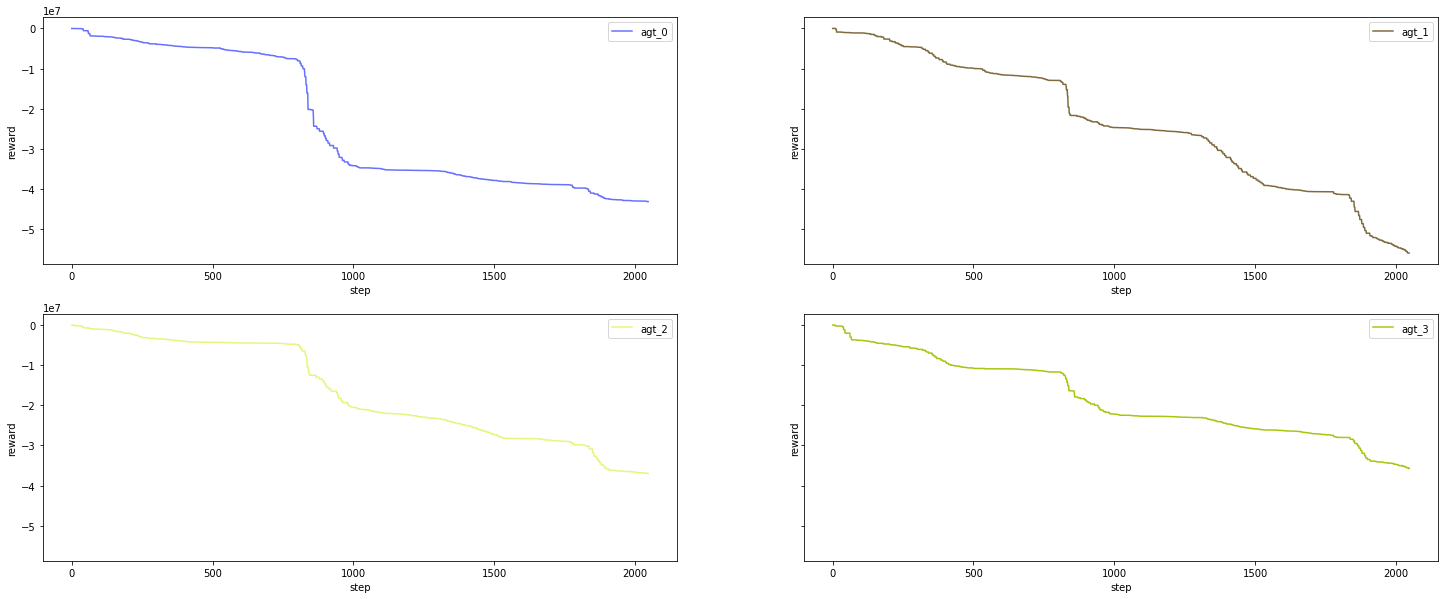

In [8]:
plot_storage(num_agents, init_cash)

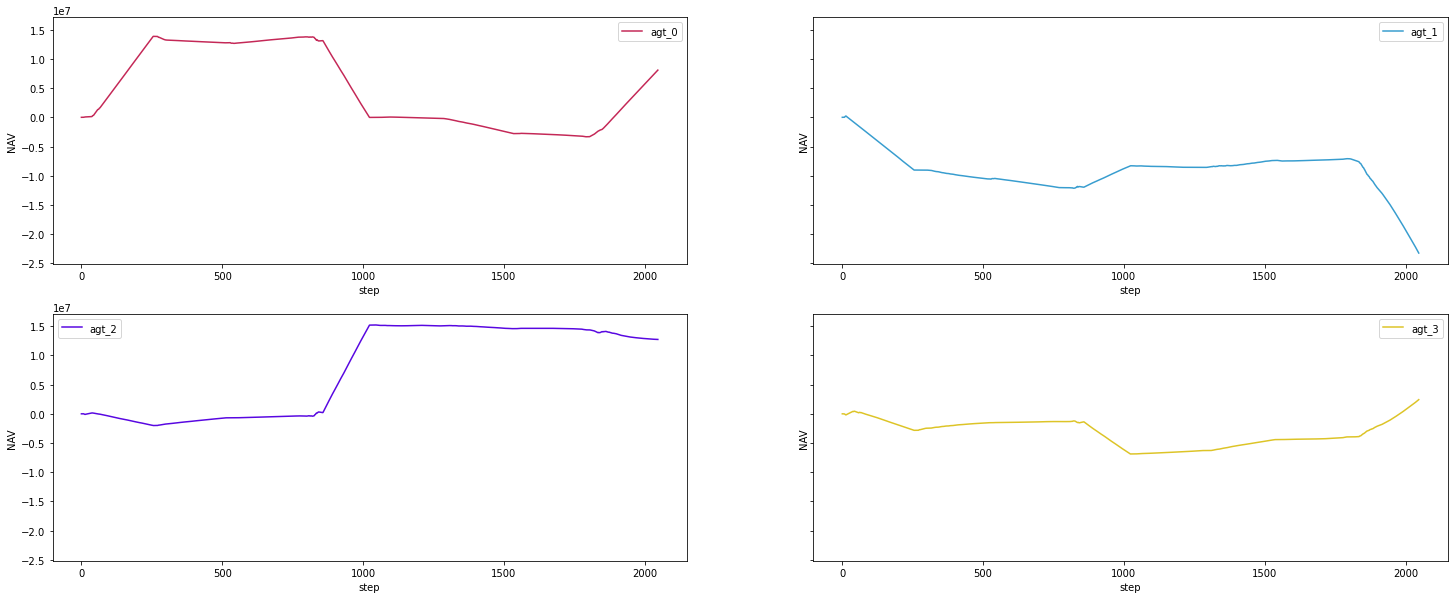

In [9]:
plot_storage(num_agents, init_cash, "step", "NAV")

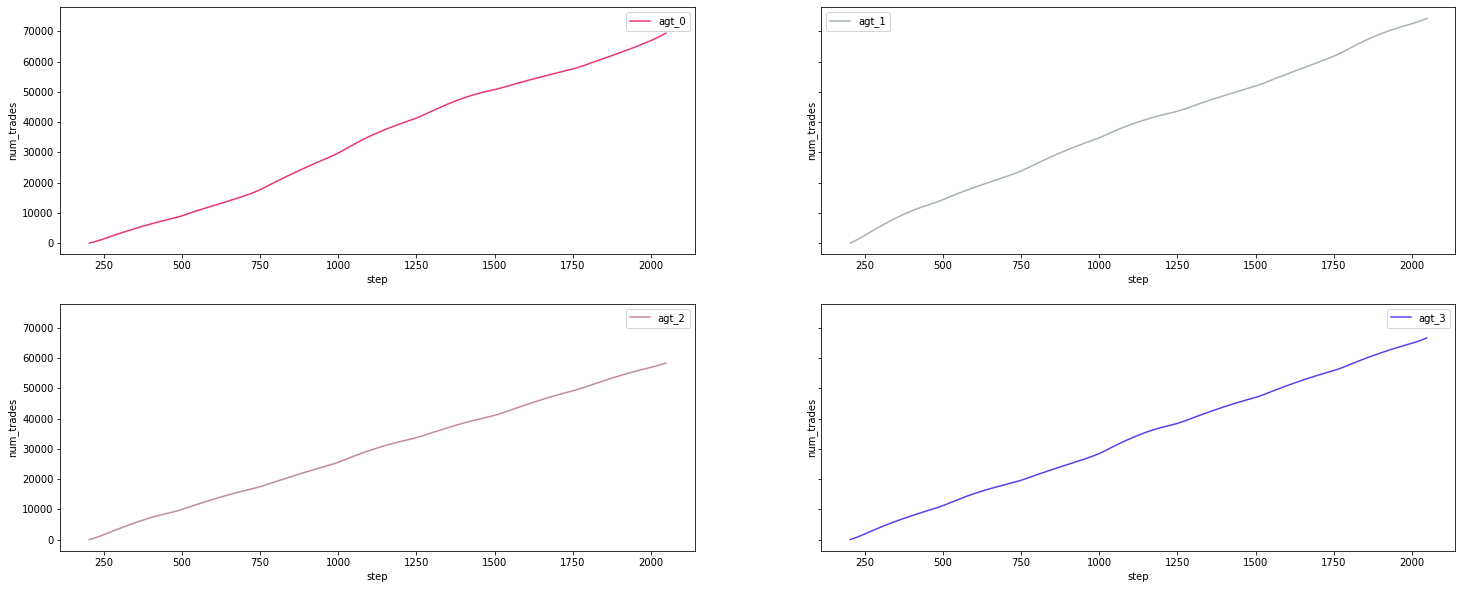

In [10]:
plot_storage(num_agents, init_cash, "step", "num_trades")

#LOB

In [0]:
g_store = ray.util.get_actor("g_store")          
#store = ray.get(g_rere.get_storage.remote())

depth = 10
bid_size, bid_price, ask_size, ask_price = ray.get(g_store.get_obs_from_agt.remote(0, depth))

#LOB order imbalance

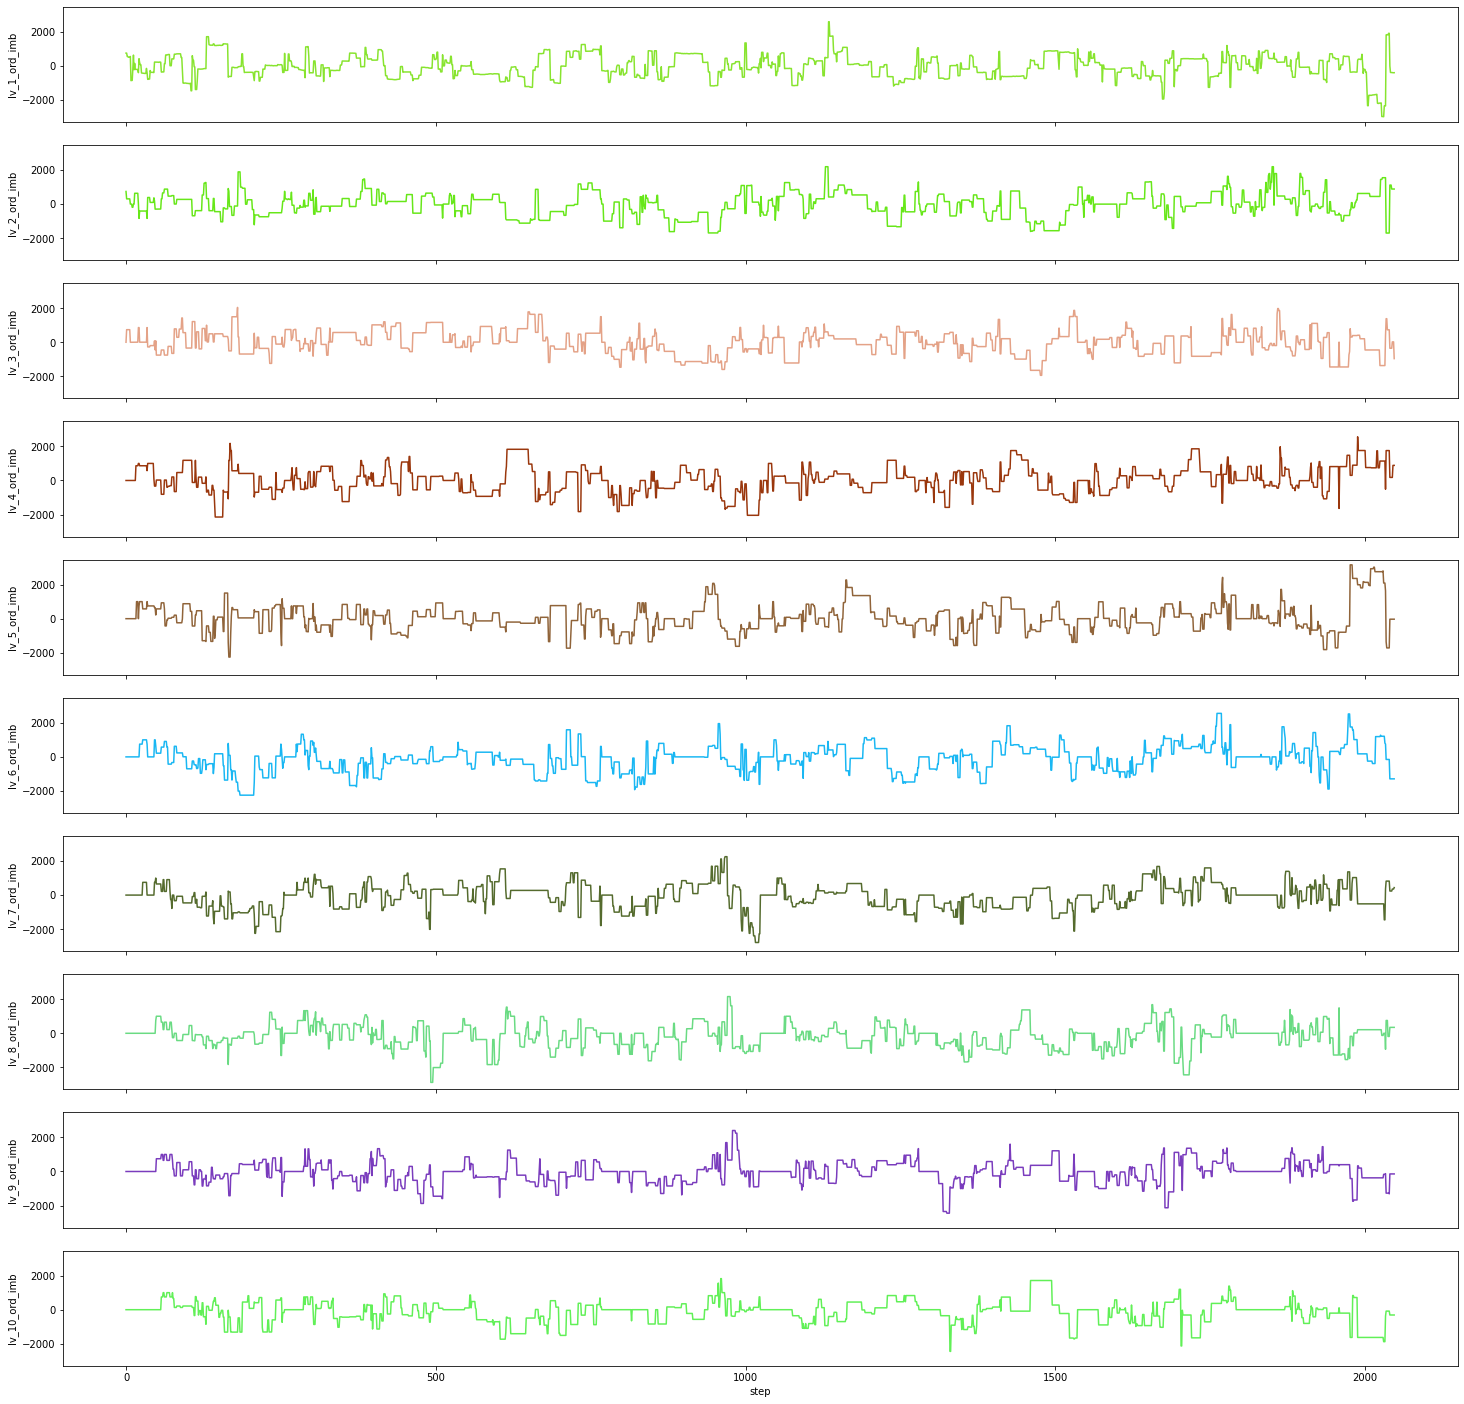

In [12]:
ord_imb_store = ord_imb(bid_size, ask_size)
plot_LOB_subplot(ord_imb_store, depth, '_ord_imb') 

#LOB sum of order imbalance

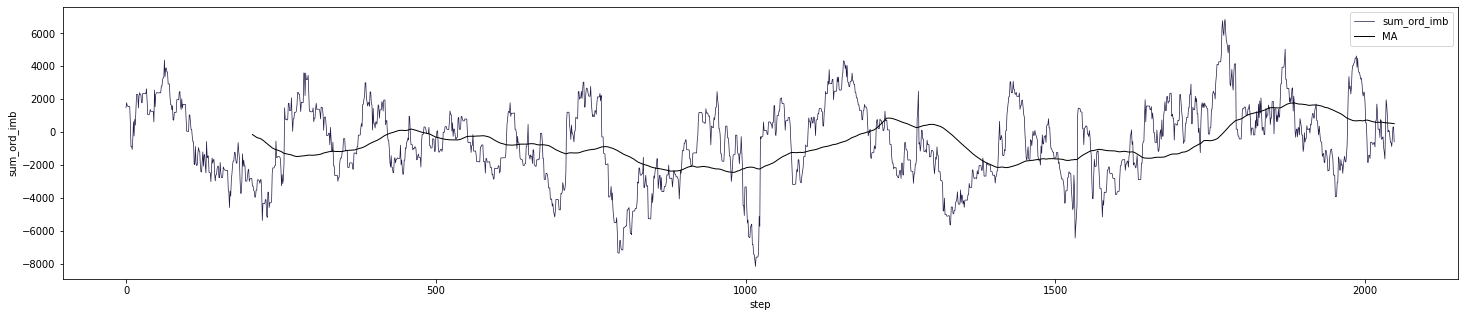

In [13]:
ord_imb_store = np.asarray(ord_imb_store)
sum_ord_imb_store = sum_ord_imb(ord_imb_store)
plot_sum_ord_imb(sum_ord_imb_store, "sum_ord_imb")

#LOB mid price (subplot)

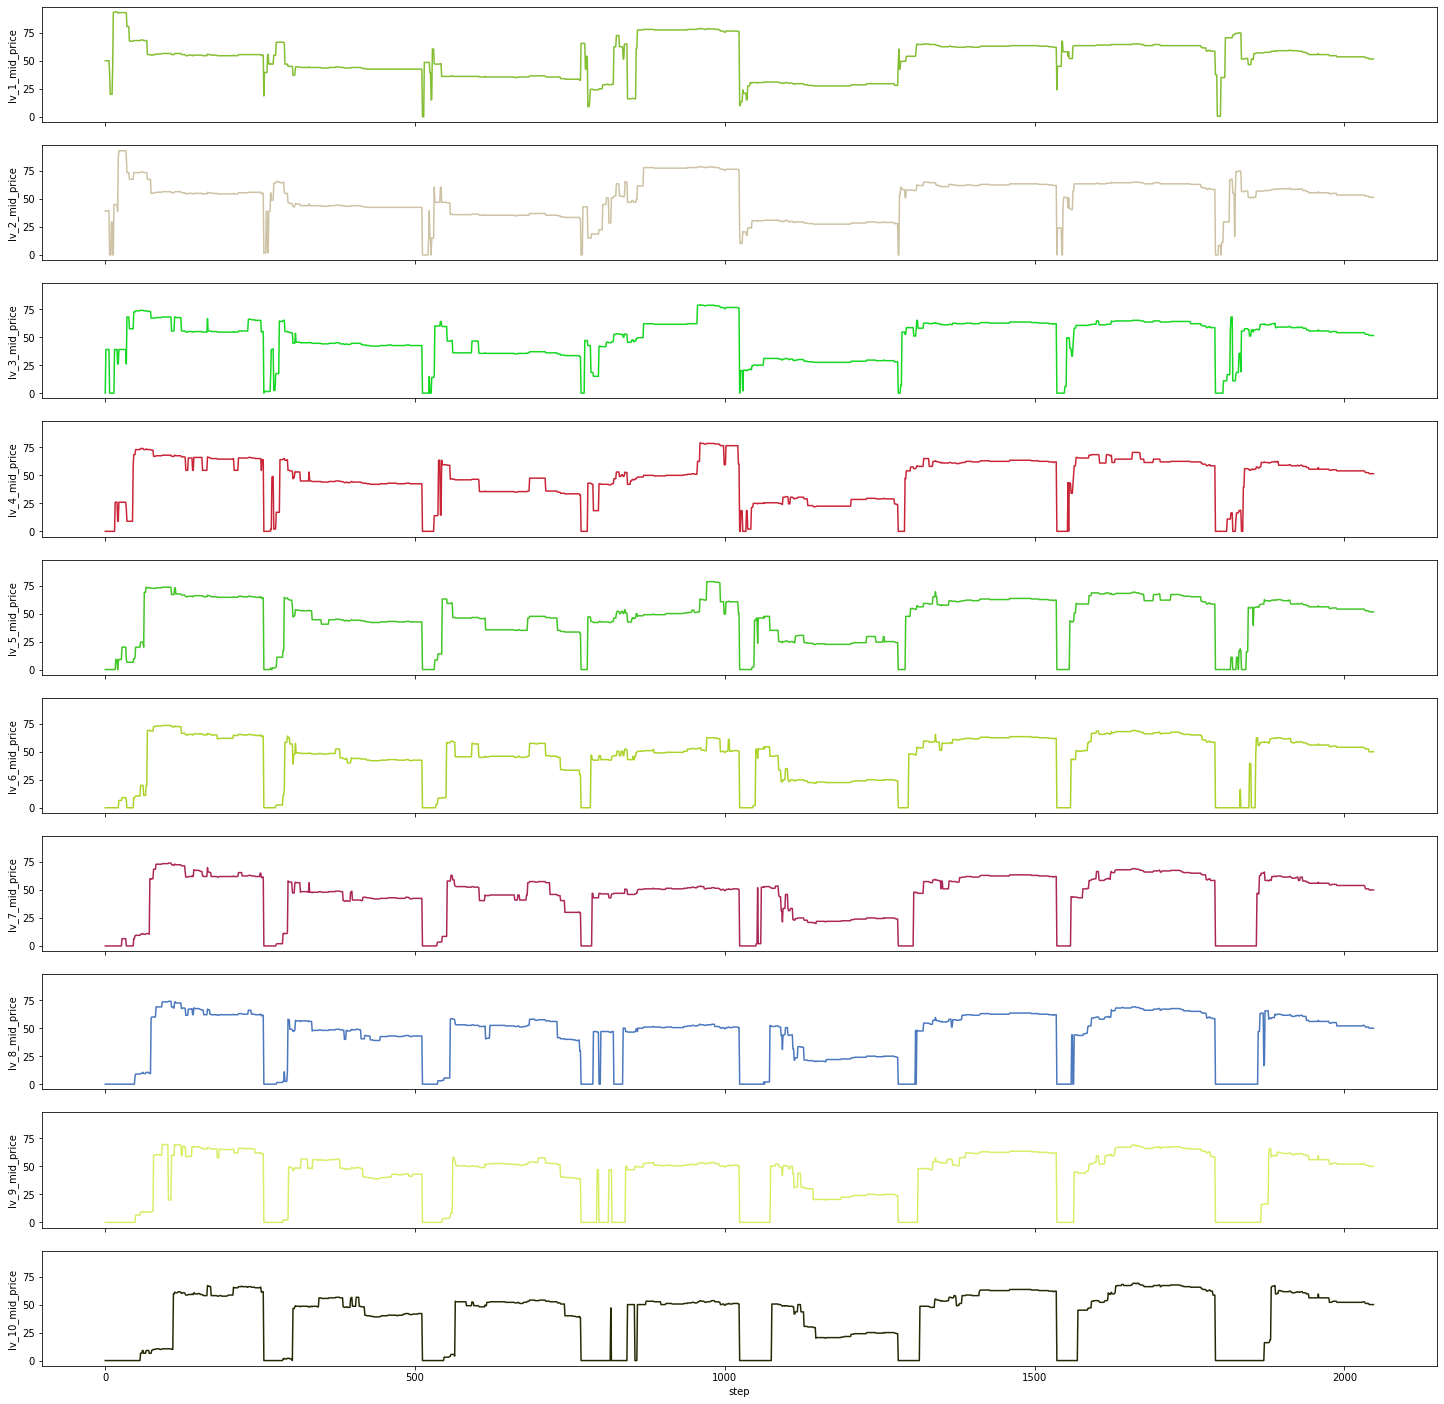

In [14]:
mid_price_store = mid_price(bid_price, ask_price)
plot_LOB_subplot(mid_price_store, depth, '_mid_price')    

#LOB mid prices 

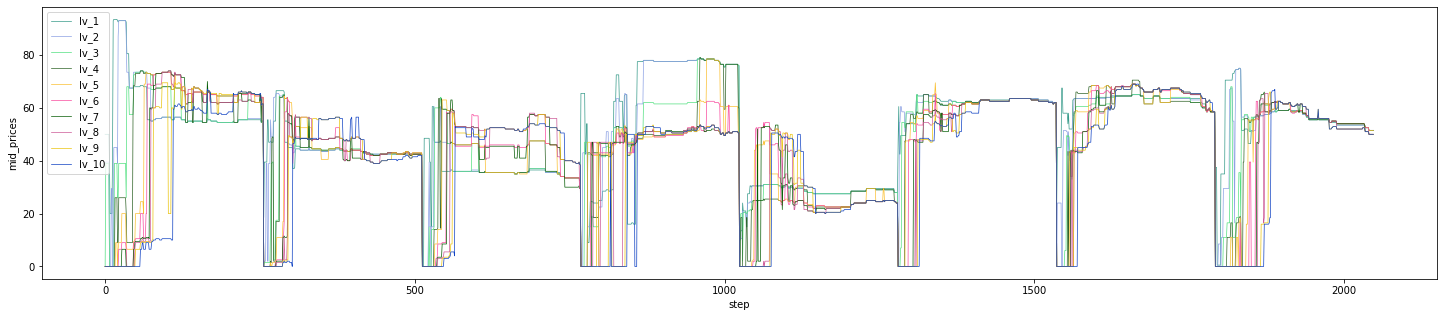

In [15]:
plot_mid_prices(mid_price_store,)

# LOB bid size

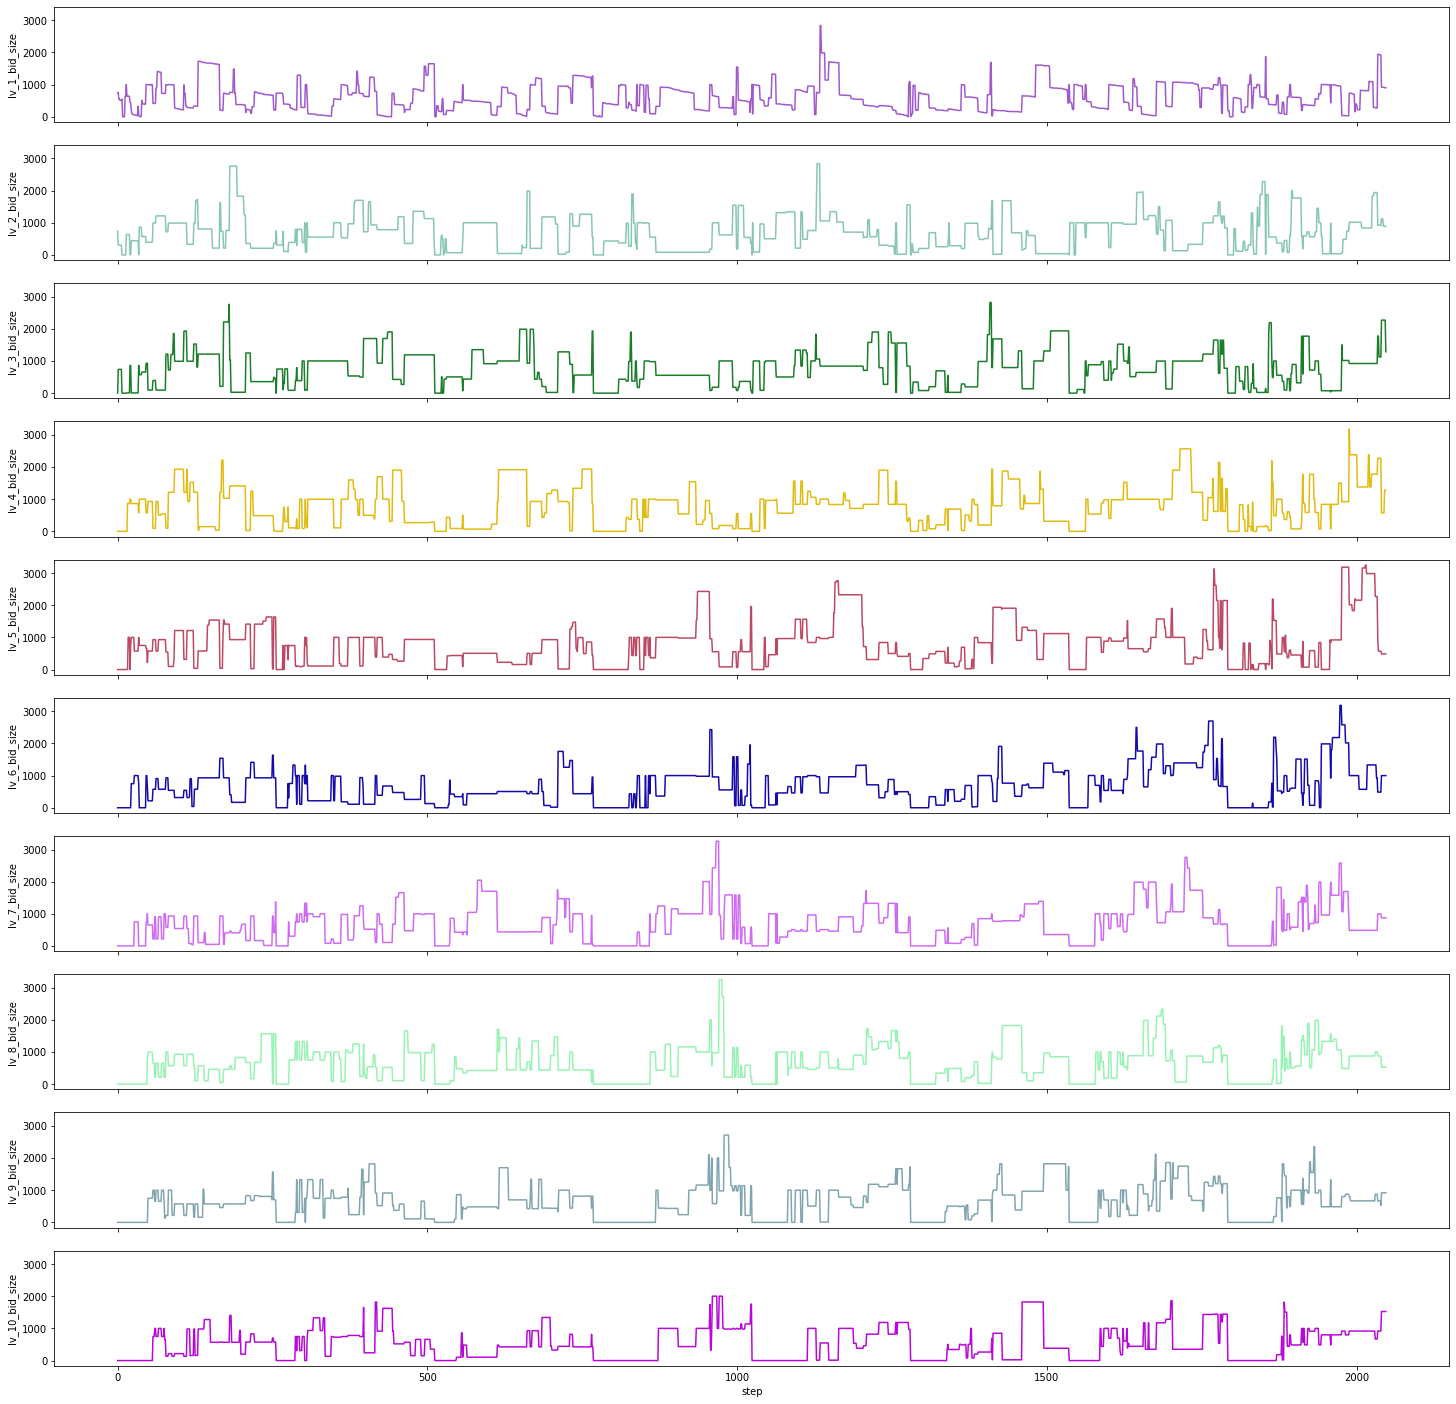

In [16]:
plot_LOB_subplot(bid_size, depth, '_bid_size')    

#LOB ask size

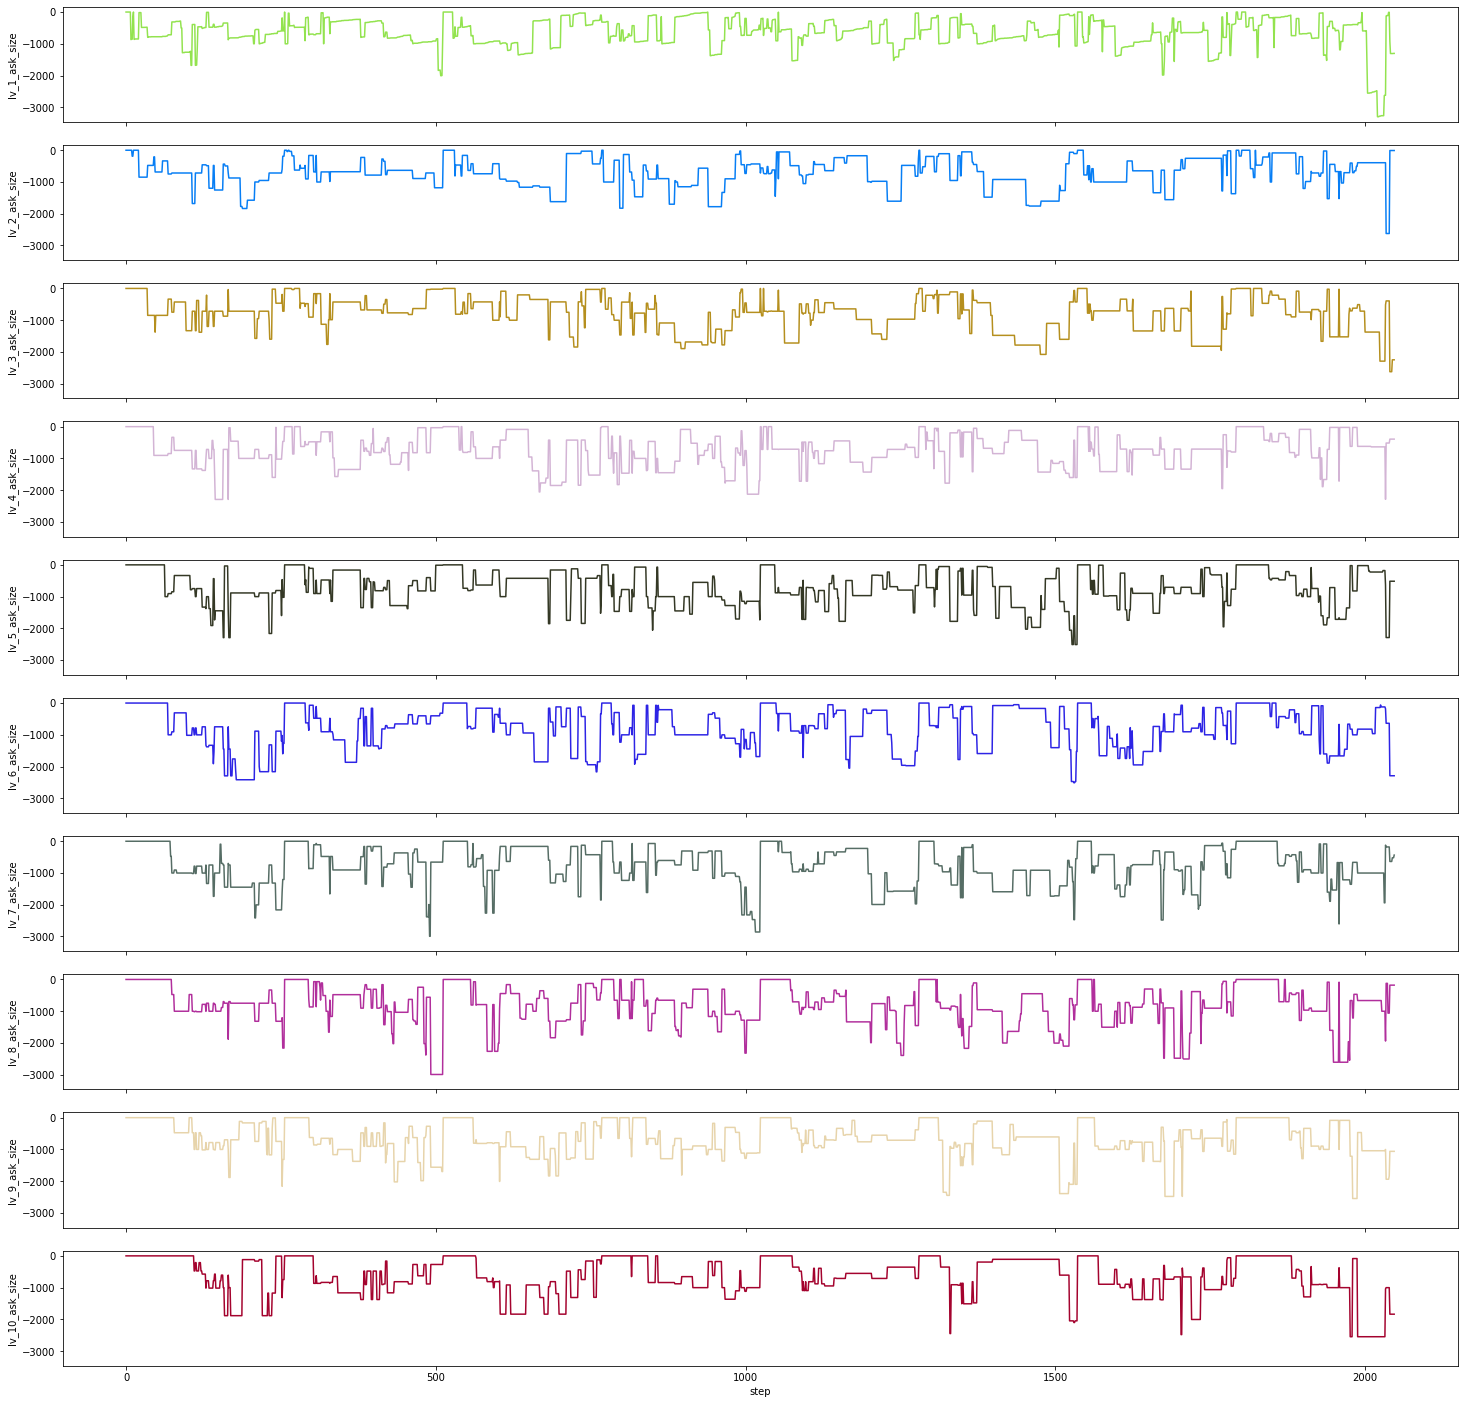

In [17]:
plot_LOB_subplot(ask_size, depth, '_ask_size')    

#LOB bid price

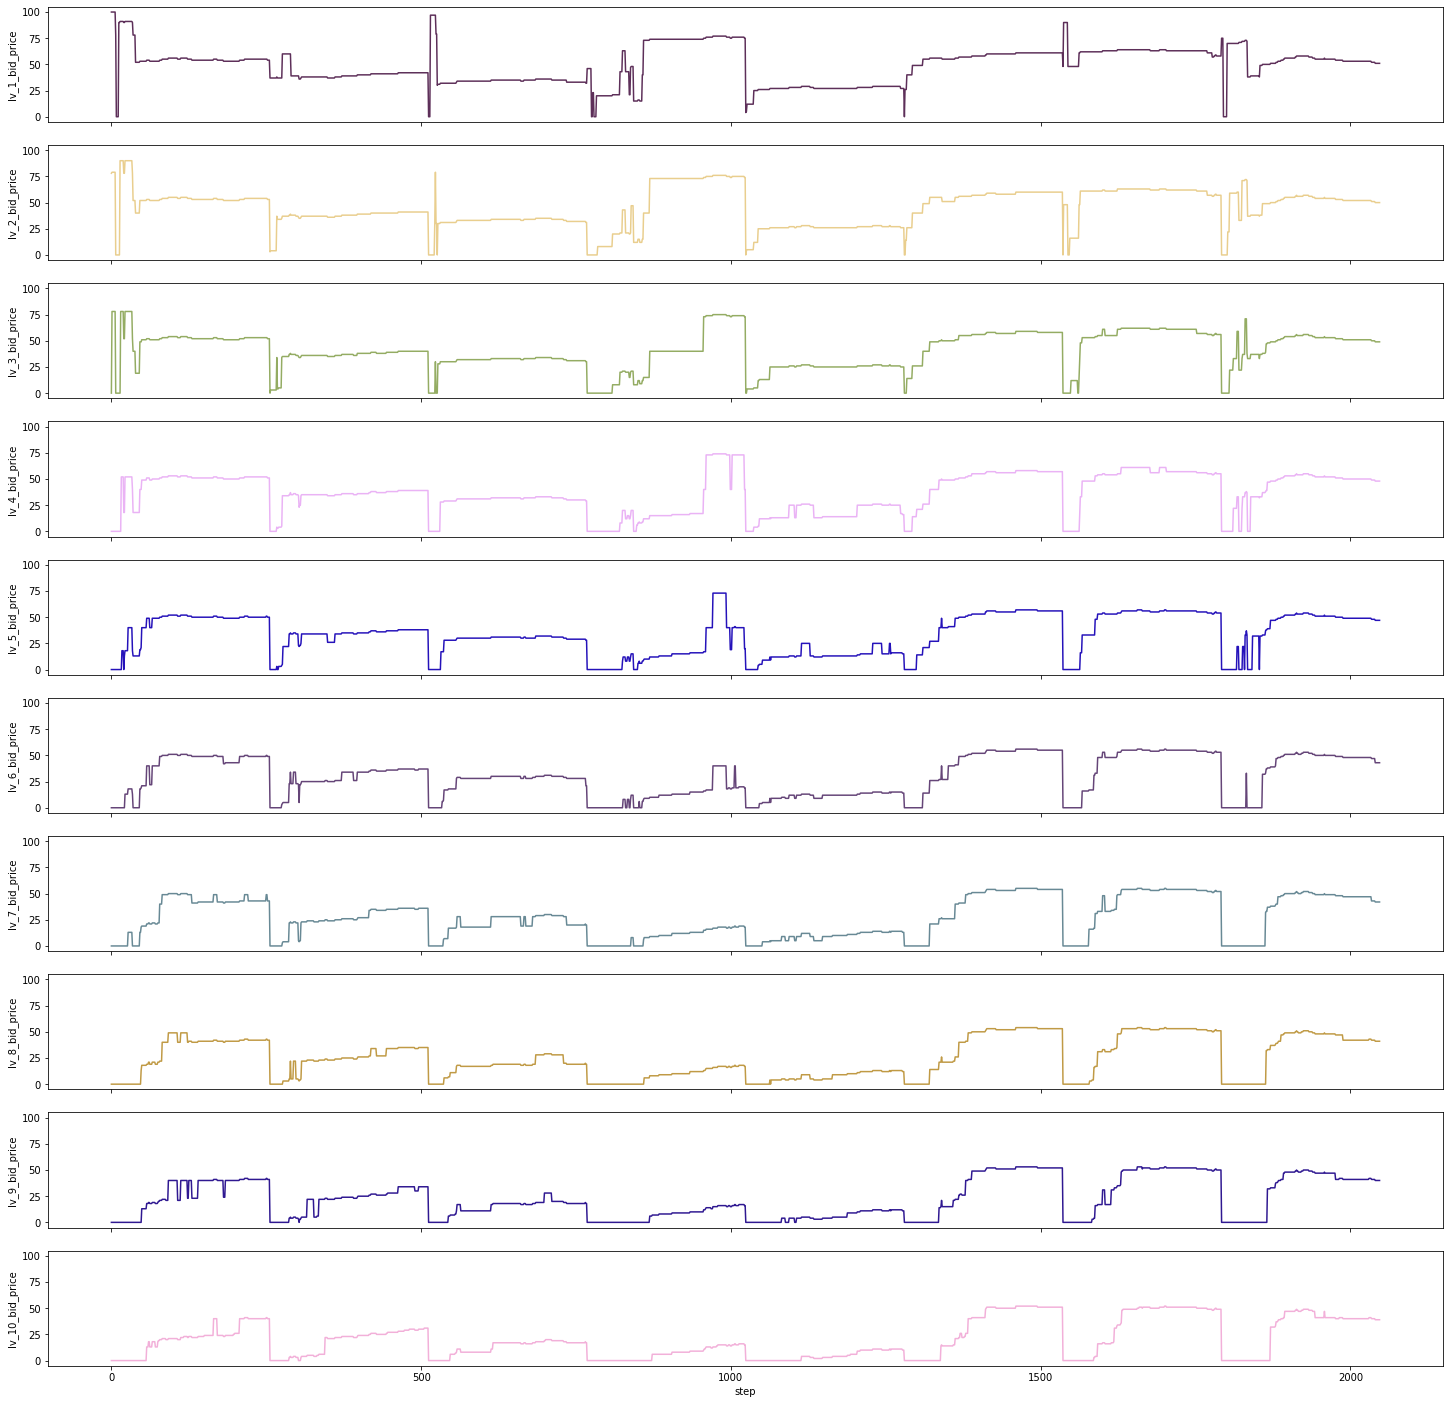

In [18]:
plot_LOB_subplot(bid_price, depth, '_bid_price')    

#LOB ask price

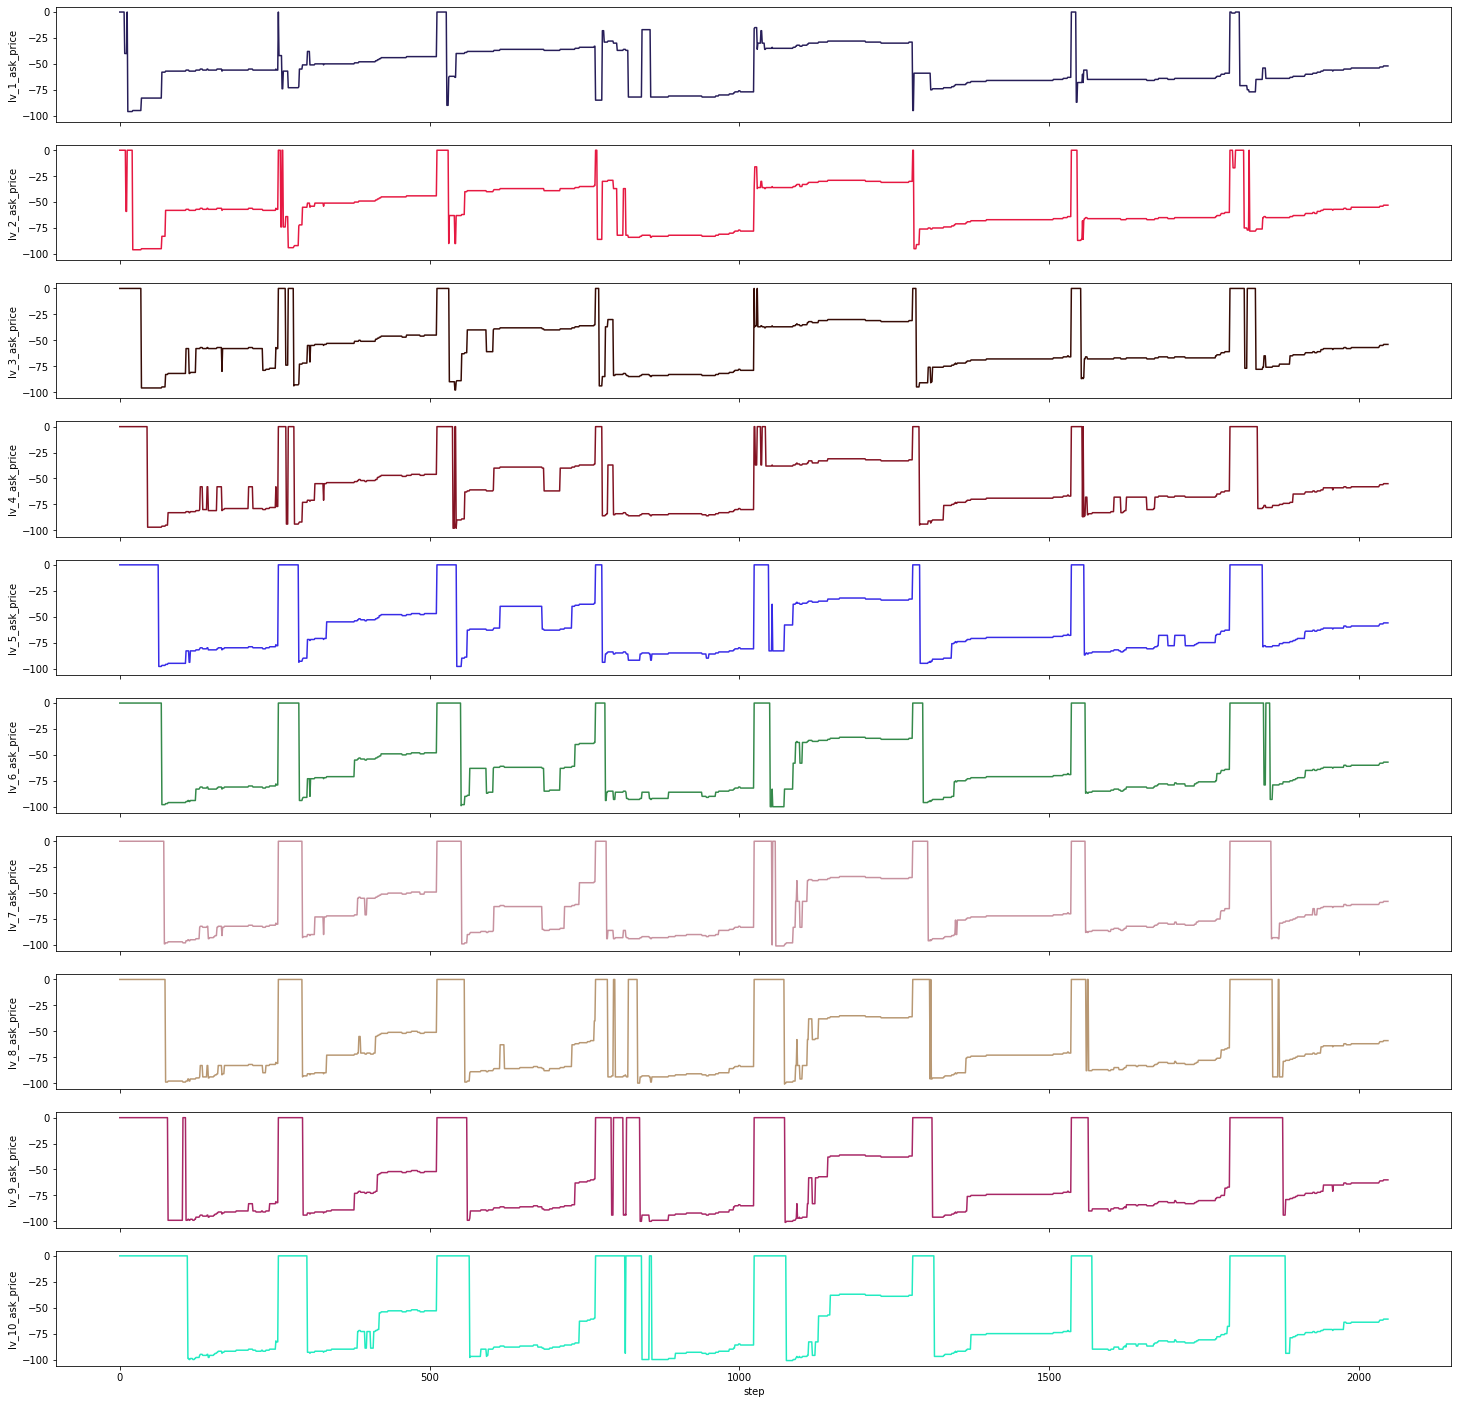

In [19]:
plot_LOB_subplot(ask_price, depth, '_ask_price')    